# Model16: Extract common functions

Now, we know what kind of common functions we need. So, I have make some functions which we used as files. So, you can find them in the `howto` directory.

* utils.py
* features.py
* containers.py

I think we already know what they are. So, just import them and use. BTW, if you want to modify them, just open those files and modify.

Also, you can find the commit which is for extracting common functions in github. Here is the comment of the commit. Now, you can understand what's this.

    refactor: extract some common functions and make them modules
    
    In python, a file can be a module. So, we can extract some common
    functions from implementation in IPython and make them as a
    or some files. After this, we can get a or some modules and we can
    import them into our source code.
    
    https://docs.python.org/2/tutorial/modules.html

In [1]:
from utils import load_buzz, select, write_result
from features import featurize, get_pos
from containers import Questions, Users, Categories

Right, now, you can use those module. 

## GMM

### Classifying questions
features: avg_pos, accuracy rate

In [2]:
%matplotlib inline
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture


def plot_gmm(X, models, n_components, covariance_type='diag', n_iter=100,
            figsize=(10, 20), suptitle=None, xlabel=None, ylabel=None):
    color_iter = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'gray', 'pink', 'lime']
    plt.figure(figsize=figsize)
    plt.suptitle(suptitle, fontsize=20)

    for i, model in enumerate(models):
        mm = getattr(mixture, model)(n_components=n_components,
                                     covariance_type=covariance_type,
                                     n_iter=n_iter)
        mm.fit(X_pos_qid)
        Y = mm.predict(X_pos_qid)

        plt.subplot(len(models), 1, 1 + i)
        for i, color in enumerate(color_iter):
            plt.scatter(X_pos_qid[Y == i, 0], X_pos_qid[Y == i, 1], .7, color=color)
        plt.title(model, fontsize=15)
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.grid()

    plt.show()

In [3]:
users = Users(load_buzz())
questions = Questions(load_buzz())
X_pos_uid = users.select(['ave_pos_uid', 'acc_ratio_uid'])
X_pos_qid = questions.select(['ave_pos_qid', 'acc_ratio_qid'])

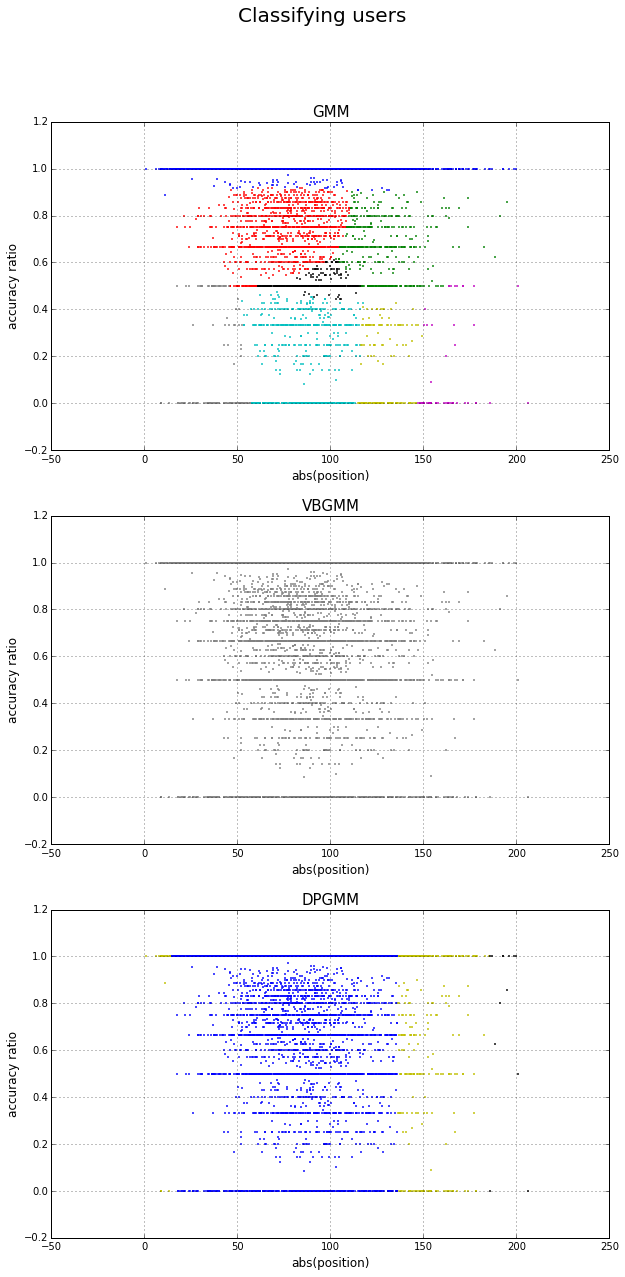

In [4]:
plot_gmm(X_pos_uid,
         models=['GMM', 'VBGMM', 'DPGMM'],
         n_components=8,
         covariance_type='diag',
         figsize=(10, 20),
         suptitle='Classifying users',
         xlabel='abs(position)',
         ylabel='accuracy ratio')

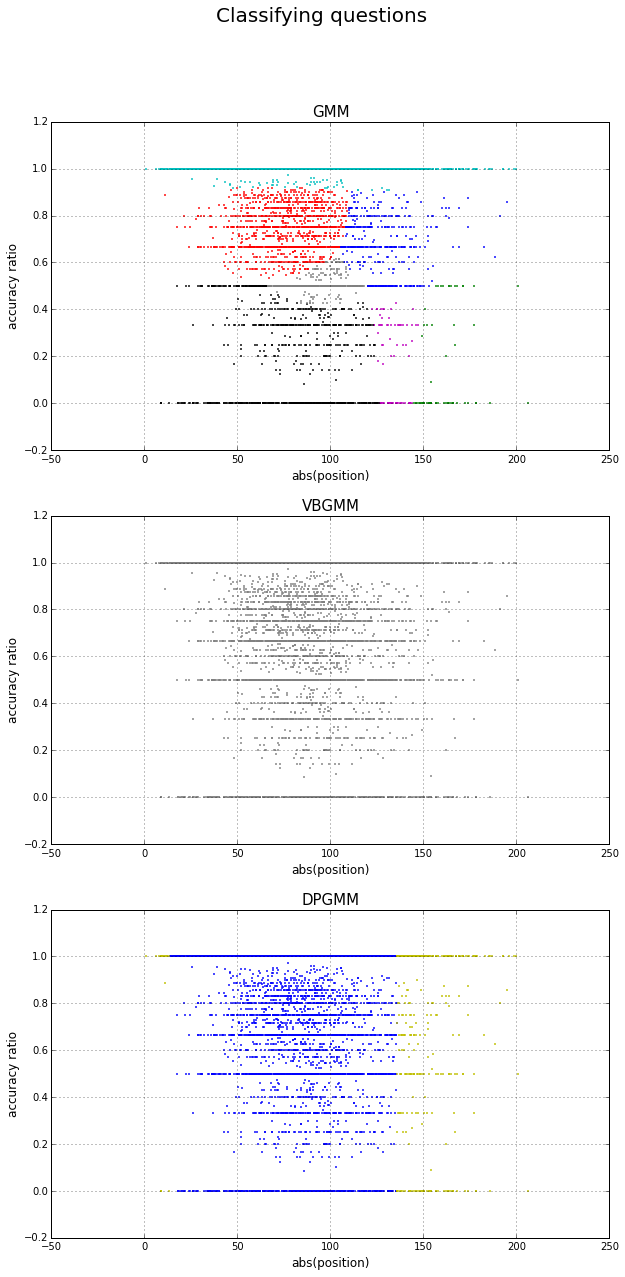

In [5]:
plot_gmm(X_pos_qid,
         models=['GMM', 'VBGMM', 'DPGMM'],
         n_components=8,
         covariance_type='diag',
         figsize=(10, 20),
         suptitle='Classifying questions',
         xlabel='abs(position)',
         ylabel='accuracy ratio')

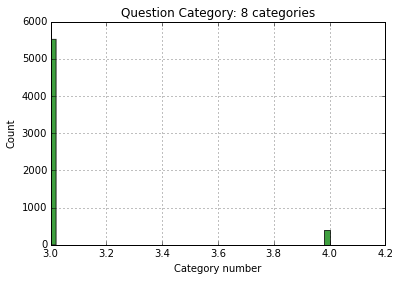

In [6]:
# Question category
n_components = 8
gmm = mixture.DPGMM(n_components=n_components, covariance_type='diag', n_iter=10**10)
gmm.fit(X_pos_qid)
pred_cat_qid = gmm.predict(X_pos_qid)

plt.hist(pred_cat_qid, bins=50, facecolor='g', alpha=0.75)
plt.xlabel("Category number")
plt.ylabel("Count")
plt.title("Question Category: " + str(n_components) + " categories")
plt.grid(True)
plt.show()

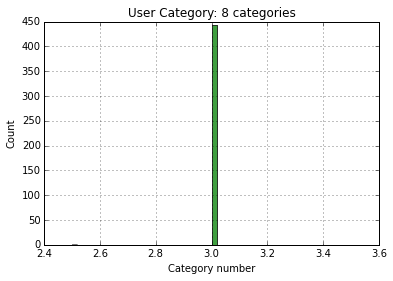

In [7]:
# User category
n_components = 8
gmm = mixture.DPGMM(n_components=n_components, covariance_type='diag', n_iter=10**10)
gmm.fit(X_pos_uid)
pred_cat_uid = gmm.predict(X_pos_uid)

plt.hist(pred_cat_uid, bins=50, facecolor='g', alpha=0.75)
plt.xlabel("Category number")
plt.ylabel("Count")
plt.title("User Category: " + str(n_components) + " categories")
plt.grid(True)
plt.show()

In [8]:
from collections import Counter


users.sub_append('cat_uid', [str(x) for x in pred_cat_uid])
questions.sub_append('cat_qid', [str(x) for x in pred_cat_qid])

# to get most frequent cat for some test data which do not have ids in train set
most_pred_cat_uid = Counter(pred_cat_uid).most_common(1)[0][0]
most_pred_cat_qid = Counter(pred_cat_qid).most_common(1)[0][0]

print(most_pred_cat_uid)
print(most_pred_cat_qid)

3
3


In [9]:
print(users[1])
print(questions[1])

{'acc_ratio_uid': 0.6465863453815262, 'ave_pos_uid': 96.724899598393577, 'cat_uid': '3'}
{'acc_ratio_qid': 0.875, 'answer': 'thomas cole', 'category': 'Fine Arts', 'cat_qid': '3', 'question': "This painter's indulgence of visual fantasy, and appreciation of different historic architectural styles can be seen in his 1840 Architect's Dream. After a series of paintings on The Last of the Mohicans, he made a three year trip to Europe in 1829, but he is better known for a trip four years earlier in which he journeyed up the Hudson River to the Catskill Mountains. FTP, name this painter of The Oxbow and The Voyage of Life series.", 'pos_token': {0: '', 1: 'painters', 2: 'indulgence', 4: 'visual', 5: 'fantasy', 68: 'this_painter', 7: 'appreciation', 64: 'mountains', 9: 'different', 10: 'historic', 11: 'architectural', 12: 'styles', 66: 'name', 77: 'series', 15: 'seen', 18: '1840', 19: 'architects', 20: 'dream', 23: 'series', 25: 'paintings', 28: 'last', 31: 'mohicans', 33: 'made', 35: 'three'

## B. Modeling

### Select model

In [10]:
regression_keys = ['category', 'q_length', 'qid', 'uid', 'answer', 'avg_pos_uid', 'avg_pos_qid']
X_train, y_train = featurize(load_buzz(), group='train', sign_val=None, extra=['sign_val', 'avg_pos'])
X_train = select(X_train, regression_keys)

In [11]:
categories = Categories(load_buzz())

In [12]:
for item in X_train:
    for key in categories[item['category']].keys():
        item[key] = categories[item['category']][key]

In [13]:
X_train

[{'acc_ratio_cat': 0.7560975609756098,
  'answer': 'thomas cole',
  'ave_pos_cat': 43.640185830429736,
  'avg_pos_qid': 51.0,
  'avg_pos_uid': 55.708333333333336,
  'category': 'fine arts',
  'q_length': 78,
  'qid': 1,
  'uid': 0},
 {'acc_ratio_cat': 0.7560975609756098,
  'answer': 'thomas cole',
  'ave_pos_cat': 43.640185830429736,
  'avg_pos_qid': 51.0,
  'avg_pos_uid': 30.973895582329316,
  'category': 'fine arts',
  'q_length': 78,
  'qid': 1,
  'uid': 1},
 {'acc_ratio_cat': 0.7560975609756098,
  'answer': 'thomas cole',
  'ave_pos_cat': 43.640185830429736,
  'avg_pos_qid': 51.0,
  'avg_pos_uid': 36.72222222222222,
  'category': 'fine arts',
  'q_length': 78,
  'qid': 1,
  'uid': 2},
 {'acc_ratio_cat': 0.7560975609756098,
  'answer': 'thomas cole',
  'ave_pos_cat': 43.640185830429736,
  'avg_pos_qid': 51.0,
  'avg_pos_uid': 49.65835411471322,
  'category': 'fine arts',
  'q_length': 78,
  'qid': 1,
  'uid': 3},
 {'acc_ratio_cat': 0.7560975609756098,
  'answer': 'thomas cole',
  'a

In [15]:
import nltk

def extract_entities(text, all=True, verbose=False):
    count = 0
    for sent in nltk.sent_tokenize(text):
        for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
            if all:
                if verbose: print(chunk)
            if type(chunk) is nltk.tree.Tree:
                count += 1
                if verbose: print(chunk.label(), ' '.join(c[0] for c in chunk.leaves()))
            elif chunk[1] == 'CD':
                count += 1
                if verbose: print('CD', chunk[0])
    return count

In [20]:
from collections import defaultdict


ne_count = defaultdict(int)
for key in questions:
    ne_count[key] = extract_entities(questions[key]['question'], all=False, verbose=False)

In [22]:
import pickle

with open('ne_count01.pkl', 'wb') as f:
    pickle.dump(ne_count, f)

In [25]:
def transform(X):
    for index, item in enumerate(X):
        uid = int(item['uid'])
        qid = int(item['qid'])

        # uid
        if int(uid) in users:
            item['acc_ratio_uid'] = users[uid]['acc_ratio_uid']
            item['cat_uid'] = users[uid]['cat_uid']
        else:
            acc = users.select(['acc_ratio_uid'])
            item['acc_ratio_uid'] = sum(acc) / float(len(acc))
            item['cat_uid'] = most_pred_cat_uid

        # qid
        if int(qid) in questions:
            item['acc_ratio_qid'] = questions[qid]['acc_ratio_qid']
            item['cat_qid'] = questions[qid]['cat_qid']
            item['ne_count'] = ne_count[qid]
        else:
            acc = questions.select(['acc_ratio_qid'])
            item['acc_ratio_qid'] = sum(acc) / float(len(acc))
            item['cat_qid'] = most_pred_cat_qid

        item['uid'] = str(uid)
        item['qid'] = str(qid)

In [26]:
transform(X_train)
X_train[1]

{'acc_ratio_cat': 0.7560975609756098,
 'acc_ratio_qid': 0.875,
 'acc_ratio_uid': 0.6465863453815262,
 'answer': 'thomas cole',
 'ave_pos_cat': 43.640185830429736,
 'avg_pos_qid': 51.0,
 'avg_pos_uid': 30.973895582329316,
 'cat_qid': '3',
 'cat_uid': '3',
 'category': 'fine arts',
 'ne_count': 11,
 'q_length': 78,
 'qid': '1',
 'uid': '1'}

In [27]:
from sklearn.feature_extraction import DictVectorizer


vec = DictVectorizer()
X_train_dict_vec = vec.fit_transform(X_train)

In [28]:
import multiprocessing
from sklearn import linear_model
from sklearn.cross_validation import train_test_split, cross_val_score
import math
from numpy import abs, sqrt


regressor_names = """
ElasticNetCV
"""
#for l1 in [0.5, 0.2, 0.7, 0.9]:
for l1 in [0.5]:
    print ("=== ElasticNetCV RMSE", "with", l1)
    for regressor in regressor_names.split():
        scores = cross_val_score(getattr(linear_model, regressor)(n_jobs=3, normalize=True, l1_ratio = l1),
                                 X_train_dict_vec, y_train,
                                 cv=2,
                                 scoring='mean_squared_error'
                                )
        print (regressor, sqrt(abs(scores)).mean())

=== ElasticNetCV RMSE with 0.5
ElasticNetCV 78.9162313223


* n_iter=10: 78.9121215405
* n_iter=100 take1: 78.9251743166
* n_iter=100 take2: 78.9268663663

### Training and testing model

In [29]:
regression_keys = ['category', 'q_length', 'qid', 'uid', 'answer', 'avg_pos_uid', 'avg_pos_qid']
X_train, y_train = featurize(load_buzz(), group='train', sign_val=None, extra=['avg_pos'])
X_train = select(X_train, regression_keys)
X_test = featurize(load_buzz(), group='test', sign_val=None, extra=['avg_pos'])
X_test = select(X_test, regression_keys)

transform(X_train)
transform(X_test)

for item in X_train:
    for key in categories[item['category']].keys():
        item[key] = categories[item['category']][key]

for item in X_test:
    for key in categories[item['category']].keys():
        item[key] = categories[item['category']][key]

In [30]:
X_train[1]

{'acc_ratio_cat': 0.7560975609756098,
 'acc_ratio_qid': 0.875,
 'acc_ratio_uid': 0.6465863453815262,
 'answer': 'thomas cole',
 'ave_pos_cat': 43.640185830429736,
 'avg_pos_qid': 51.0,
 'avg_pos_uid': 30.973895582329316,
 'cat_qid': '3',
 'cat_uid': '3',
 'category': 'fine arts',
 'ne_count': 11,
 'q_length': 78,
 'qid': '1',
 'uid': '1'}

In [31]:
X_test[1]

{'acc_ratio_cat': 0.65625,
 'acc_ratio_qid': 0.6428571428571429,
 'acc_ratio_uid': 0.6712328767123288,
 'answer': 'david hilbert',
 'ave_pos_cat': 18.712499999999999,
 'avg_pos_qid': 15.571428571428571,
 'avg_pos_uid': 36.31506849315068,
 'cat_qid': '3',
 'cat_uid': '3',
 'category': 'mathematics',
 'ne_count': 10,
 'q_length': 105,
 'qid': '9967',
 'uid': '131'}

In [32]:
vec = DictVectorizer()
vec.fit(X_train + X_test)
X_train = vec.transform(X_train)
X_test = vec.transform(X_test)

In [ ]:
for l1_ratio in [0.72, 0.7]:
    print('=== l1_ratio:', l1_ratio)
    regressor = linear_model.ElasticNetCV(n_jobs=3, normalize=True, l1_ratio=l1_ratio)
    regressor.fit(X_train, y_train)
    print(regressor.coef_)
    print(regressor.alpha_)
    predictions = regressor.predict(X_test)
    write_result(load_buzz()['test'], predictions, file_name=str(l1_ratio)+'guess.csv')

=== l1_ratio: 0.72
[ 16.39629351  26.25390912  23.56422793 ...,   8.04292141   1.32720446
   5.03593465]
0.000392987081188
=== l1_ratio: